In [46]:
### TODO import libraries and apply overlay
from PIL import Image
import PIL
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import Overlay, allocate
import re
import requests
# from bs4 import BeautifulSoup
#applying resizer overlay
resize_design = Overlay("resizer.bit")

In [11]:
### TODO download cat images into the folder `cats/`

url = "https://wallpapersafari.com/free-cat-wallpapers-for-desktop/"
headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36"}
response = requests.request("GET", url, headers=headers)
data = BeautifulSoup(response.text, 'html.parser')# find all with the image tag
images = data.find_all('img', src=True)
print('Number of Images: ', len(images))
# select src tag
image_src = [x['src'] for x in images]# select only jp format images
image_src = [x for x in image_src if x.endswith('.jpg')]
image_count = 1
for image in image_src:
    with open('cats/image_'+str(image_count)+'.jpg', 'wb') as f:
        res = requests.get(image)
        f.write(res.content)
    image_count = image_count+1
    
##TODO LIMIT THE NUMBER

Number of Images:  62


In [141]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0

pl_exec_times = []
ps_exec_times = []

In [134]:
# image_in, image_out: PIL.Image
# image_out_size: (width, height)
def fpga_resize(image_in, image_out_size):

    global exepl_time, end_time, start_time

    
    old_width, old_height = image_in.size
    new_width, new_height = image_out_size
    
    in_buffer = allocate(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
    out_buffer = allocate(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)
    
    
    
    in_buffer[:] = np.array(image_in)
    
    resizer.write(0x10, old_height)
    resizer.write(0x18, old_width)
    resizer.write(0x20, new_height)
    resizer.write(0x28, new_width)
    
    start_time = time.time()
    
    
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer) 
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    resized_imgg = Image.fromarray(out_buffer)
    
    end_time = time.time()
    exepl_time = exepl_time + (end_time - start_time)
    
    pl_exec_times.append(end_time - start_time)
    
    return resized_imgg

In [96]:
def fpga_resize_images(image_paths):
    img_list=[]
    for image in image_paths:
        original_image = Image.open(image)
        img_list.append(fpga_resize(original_image,(64,64)))
    return img_list

In [142]:
def cpu_resize_images(image_paths):
    imgcpu_list = []
    global execpu_time,end_time,start_time
    for _ in image_paths:
        original_image = Image.open(_)
        old_width, old_height = original_image.size
    
        new_width = 64
        new_height = 64

        start_time = time.time()
        resized_image = original_image.resize((new_width, new_height), Image.BILINEAR)
        end_time = time.time()
        execpu_time = execpu_time + (end_time - start_time)
        
        imgcpu_list.append(resized_image)
        ps_exec_times.append(end_time - start_time)
        
    return imgcpu_list

In [99]:
image_paths = !ls cats/*jpg

In [143]:
exepl_time = 0
img_list = fpga_resize_images(image_paths)

In [144]:
execpu_time=0
imgcpu_list=cpu_resize_images(image_paths)

In [137]:
# TODO timeit fpga_resize_images(image_paths)
print("{:.3f}".format(exepl_time), "Seconds")


0.573 Seconds


In [138]:
# TODO timeit cpu_resize_images(image_paths)
print("{:.3f}".format(execpu_time), "Seconds")


2.733 Seconds


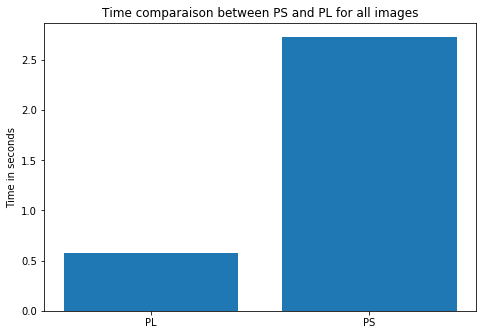

In [153]:
# TODO visualization of comparison values using plots

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
method = ['PS', 'PL']
timing = [execpu_time, exepl_time]
ax.bar(method,timing)
plt.title('Time comparaison between PS and PL for all images')
plt.ylabel('Time in seconds')

plt.show()

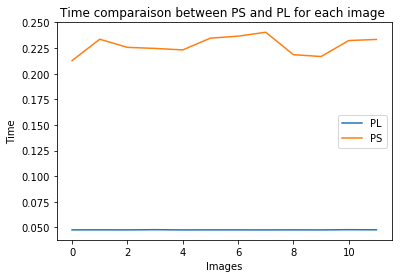

In [154]:




x1 = [i for i in range(len(image_paths))]
y1 = pl_exec_times

# plotting the line 1 points 
plt.plot(x1, y1, label = "PL")
# line 2 points
x2 = [i for i in range(len(image_paths))]
y2 = ps_exec_times
# plotting the line 2 points 
plt.plot(x2, y2, label = "PS")
plt.xlabel('Images')
# Set the y axis label of the current axis.
plt.ylabel('Time')
# Set a title of the current axes.
plt.title('Time comparaison between PS and PL for each image ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


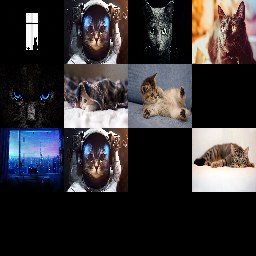

In [56]:
w,h = img_list[0].size 
grid=Image.new('RGB', size=(4*w,4*h))    
grid_w,grid_h =grid.size

for i, img in enumerate(img_list):
    grid.paste(img,box=(i%5*w,i//4*h))
    
grid